In [252]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import r2_score

In [231]:
df = pd.read_csv("Datas/data_rudy.csv")

In [232]:
df.head(1)

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,day,month,day_number,year,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16,Saturday,1,0,2011,0


## Train Test Split

Split des données avant (train) et après(test) Septembre 2012

In [233]:
X_train = df[(df.month <=  8) | (df.year == 2011)].drop(["datetime","count"], axis=1)
X_test = df[(df.month >  8) & (df.year == 2012)].drop(["datetime","count"], axis=1)
y_train = np.log1p(df[(df.month <=  8) | (df.year == 2011)]["count"])
y_test = np.log1p(df[(df.month >  8) & (df.year == 2012)]["count"])

## Pipelines

In [234]:
one_hot_features = ["weather", "holiday", "workingday", "season", "month", "day", "year"]
standard_feature = ["temp", "humidity", "windspeed", "day_number", "hour"]

one_hot_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
standard_pipeline = make_pipeline(StandardScaler())

processor = make_column_transformer((one_hot_pipeline, one_hot_features), (standard_pipeline, standard_feature))

In [235]:
rfr = make_pipeline(processor, RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='squared_error',
                      max_depth=10, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0, min_samples_leaf=6,
                      min_samples_split=9, min_weight_fraction_leaf=0.0,
                      n_estimators=150, random_state=1))
                      
lgbm = make_pipeline(processor, LGBMRegressor())

## Scoring des modèle

In [238]:
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print(rfr.score(X_test, y_test))

print("Score R2 :", r2_score(y_test, y_pred))

0.7247767401632359
Score R2 : 0.7247767401632359


In [239]:
lgbm.fit(X_train, y_train)
yl_pred = lgbm.predict(X_test)
print(lgbm.score(X_test, y_test))

print("Score R2 :", r2_score(y_test, yl_pred))

0.948016894587881
Score R2 : 0.948016894587881


In [ ]:
from sklearn.model_selection import learning_curve

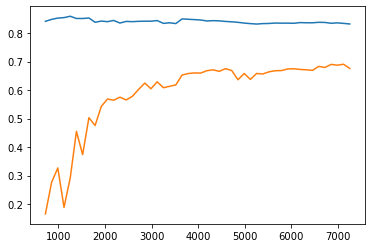

In [257]:
train_size, train_score, val_score = learning_curve(rfr, X_train, y_train, train_sizes=np.linspace(0.1,1,50), scoring="r2")

plt.plot(train_size, train_score.mean(axis=1))
plt.plot(train_size, val_score.mean(axis=1))

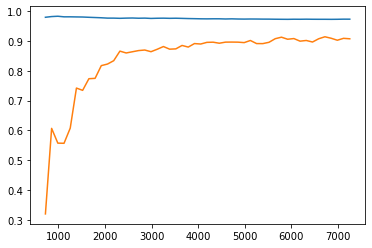

In [256]:
train_size, train_score, val_score = learning_curve(lgbm, X_train, y_train, train_sizes=np.linspace(0.1,1,50))

plt.plot(train_size, train_score.mean(axis=1))
plt.plot(train_size, val_score.mean(axis=1))

## Prédictions

In [249]:
def make_prediction(y, model):
    pred = np.array(y)
    data_pred = pd.DataFrame(pred, columns=list(X_train.columns))
    for col in list(data_pred.columns):
        try:
            data_pred[col] = data_pred[col].astype(float)
        except:
            pass
    return np.exp(model.predict(data_pred))

In [250]:
print(make_prediction(y=[[4, 1, 0, 1, 25, 30, 20, "Monday", 4, 4370, 2022, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 360, 2011, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 725, 2012, 10]], model=rfr))
                
print(make_prediction(y=[[4, 1, 0, 1, 25, 30, 20, "Monday", 4, 4370, 2022, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 360, 2011, 10],
                [4, 1, 0, 1, 25, 30, 20, "Monday", 4, 725, 2012, 10]],model=lgbm))

[265.88365233 227.81748469 285.7554653 ]
[338.14838561 211.94094152 338.14838561]
